In [1]:
import pybroker as pb
from pybroker.ext.data import AKShare
import akshare as ak
from pybroker import Strategy, StrategyConfig, ExecContext
from backtest import get_last_invest
import pandas as pd
from loguru import logger

pb.enable_data_source_cache('my_strategy')

/home/liubei/miniconda3/envs/turtle/lib/python3.12/site-packages/py_mini_racer/py_mini_racer.py:15: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
2025-12-28 21:11:37.842918215 [W:onnxruntime:Default, device_discovery.cc:164 DiscoverDevicesForPlatform] GPU device discovery failed: device_discovery.cc:89 ReadFileContents Failed to open file: "/sys/class/drm/card0/device/vendor"


In [2]:
# 定义全局参数 "stock_code"（股票代码）、"percent"（持仓百分比）和 "stop_profit_pct"（止盈百分比）
pb.param(name='stock_code', value='601601')
pb.param(name='percent', value=1)
pb.param(name='stop_loss_pct', value=10)
pb.param(name='stop_profit_pct', value=10)

# 1. 启用缓存（可选）
pb.enable_data_source_cache("all_in_cache")
pb.enable_indicator_cache("all_in_ind")

In [3]:
config = StrategyConfig(initial_cash=20000)

In [4]:
strategy = Strategy(AKShare(), '1/1/2025', '7/1/2025', config)

In [5]:
def get_yesterday_trade_date(date):
    # 交易日历
    trade_df = ak.tool_trade_date_hist_sina()
    trade_df["trade_date"] = pd.to_datetime(trade_df["trade_date"], errors='coerce')
    trade_list = trade_df["trade_date"].dt.strftime('%Y%m%d').to_list()
    index = trade_list.index(date)
    return trade_list[index-1]

In [6]:
def buy_with_stop_loss(ctx: ExecContext):
    cur_date = ctx.date[-1].astype('datetime64[D]').item().strftime('%Y%m%d')
    yesterday = get_yesterday_trade_date(cur_date)
    logger.info(f"当前交易日：{cur_date}, 前一天：{yesterday}")
    _, invest_json = get_last_invest(yesterday)
    pos = ctx.long_pos()
    if not invest_json:
        return
    else:
        if not pos:
            if invest_json["user_not_held"] == "buy":
                logger.info("buy buy buy")
            # 计算目标股票数量，根据 "percent" 参数确定应购买的股票数量
                ctx.buy_shares = ctx.calc_target_shares(pb.param(name='percent'))
                ctx.hold_bars = 100
        else:
            if invest_json["user_held"] == "sell":
                logger.info("sell sell sell")
                ctx.sell_all_shares()
            elif invest_json["user_held"] == "wait":
                ctx.sell_shares = pos.shares
                # 设置止盈点位，根据 "stop_profit_pct" 参数确定止盈点位
                ctx.stop_profit_pct = pb.param(name='stop_profit_pct')
                ctx.stop_loss_pct = pb.param(name='stop_loss_pct')

In [7]:
strategy.add_execution(buy_with_stop_loss,  symbols=[pb.param(name='stock_code')])

In [8]:
result = strategy.backtest()

Backtesting: 2025-01-01 00:00:00 to 2025-07-01 00:00:00

Loaded cached bar data.

Test split: 2025-01-02 00:00:00 to 2025-07-01 00:00:00


  0% (0 of 118) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--2025-12-28 21:11:39.524 | INFO     | __main__:buy_with_stop_loss:4 - 当前交易日：20250102, 前一天：20241231
2025-12-28 21:11:39.526 | WARNING  | backtest:get_last_invest:14 - 20241231历史数据不存在
  0% (1 of 118) |                        | Elapsed Time: 0:00:00 ETA:   0:00:232025-12-28 21:11:39.776 | INFO     | __main__:buy_with_stop_loss:4 - 当前交易日：20250103, 前一天：20250102
2025-12-28 21:11:39.779 | INFO     | backtest:get_last_invest:19 - 20250102
{'stock_symbol': '601601', 'stock_name': '中国太保', 'user_held': 'sell', 'user_not_held': 'wait', 'reasoning': ['行情层面：股价跌破20日均线，短期趋势偏弱，且当日跌幅达5.42%，资金流出压力较大', '技术指标：RSI进入超卖区域（35.68），但MACD仍处于弱势区间，未见明显反转信号', '基本面支撑：2024年前三季度业绩表现亮眼，净利润同比增长65.5%，估值低于行业均值，具备长期修复空间', '风险提示：短期内若无法在31元附近形成有效支撑，可能进一步下探至30元附近；此外，长航转型不及预期或资本市场波动可能带来额外风险'], 'confidence_level': 'medium', 'action_suggestion': '已持有者建议逢高减仓，锁定部分收益；未持有者建议观望，等待股价企稳或明确反弹信号后再考虑建仓'}
2025-12-28 21:11:40.015 | INFO     | __main__:buy_with_stop


Finished backtest: 0:00:33


### 查看投资组合的每日余额

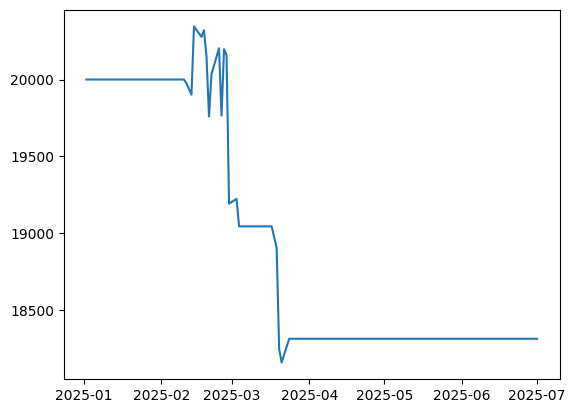

In [9]:
import matplotlib.pyplot as plt

chart = plt.subplot2grid((3, 2), (0, 0), rowspan=3, colspan=2)
chart.plot(result.portfolio.index, result.portfolio['market_value'])

In [10]:
result.portfolio

,cash,equity,margin,market_value,pnl,unrealized_pnl,fees
date,,,,,,,
2025-01-02,20000.00,20000.00,0.0,20000.00,0.00,0.0,0.0
2025-01-03,20000.00,20000.00,0.0,20000.00,0.00,0.0,0.0
2025-01-06,20000.00,20000.00,0.0,20000.00,0.00,0.0,0.0
2025-01-07,20000.00,20000.00,0.0,20000.00,0.00,0.0,0.0
2025-01-08,20000.00,20000.00,0.0,20000.00,0.00,0.0,0.0
...,...,...,...,...,...,...,...
2025-06-25,18311.49,18311.49,0.0,18311.49,-1688.51,0.0,0.0
2025-06-26,18311.49,18311.49,0.0,18311.49,-1688.51,0.0,0.0
2025-06-27,18311.49,18311.49,0.0,18311.49,-1688.51,0.0,0.0


### 持仓

In [11]:
result.positions

long_shares  short_shares  close    equity  market_value  \
symbol date                                                                   
601601 2025-02-11          617             0  32.14  19830.38      19830.38   
       2025-02-12          617             0  32.08  19793.36      19793.36   
       2025-02-13          617             0  32.02  19756.34      19756.34   
       2025-02-14          617             0  32.74  20200.58      20200.58   
       2025-02-17          617             0  32.63  20132.71      20132.71   
       2025-02-18          617             0  32.70  20175.90      20175.90   
       2025-02-19          617             0  32.42  20003.14      20003.14   
       2025-02-20          617             0  31.79  19614.43      19614.43   
       2025-02-21          617             0  32.24  19892.08      19892.08   
       2025-02-24          617             0  32.51  20058.67      20058.67   
       2025-02-25          617             0  31.80  19620.60      19620.60   
       2025-02-26          617             0  32.50  20052.50      20052.50   
       2025-02-27          617             0  32.44  20015.48      20015.48   
       2025-02-28          617             0  30.87  19046.79      19046.79   
       2025-03-03          617             0  30.92  19077.64      19077.64   
       2025-03-18          572             0  33.16  18967.52      18967.52   
       2025-03-19          572             0  33.03  18893.16      18893.16   
       2025-03-20          572             0  31.88  18235.36      18235.36   
       2025-03-21          572             0  31.73  18149.56      18149.56   

                   margin  unrealized_pnl  
symbol date                                
601601 2025-02-11     0.0          -24.68  
       2025-02-12     0.0          -61.70  
       2025-02-13     0.0          -98.72  
       2025-02-14     0.0          345.52  
       2025-02-17     0.0          277.65  
       2025-02-18     0.0          320.84  
       2025-02-19     0.0          148.08  
       2025-02-20     0.0         -240.63  
       2025-02-21     0.0           37.02  
       2025-02-24     0.0          203.61  
       2025-02-25     0.0         -234.46  
       2025-02-26     0.0          197.44  
       2025-02-27     0.0          160.42  
       2025-02-28     0.0         -808.27  
       2025-03-03     0.0         -777.42  
       2025-03-18     0.0          -68.64  
       2025-03-19     0.0         -143.00  
       2025-03-20     0.0         -800.80  
       2025-03-21     0.0         -886.60

In [12]:
result.trades

,type,symbol,entry_date,exit_date,entry,exit,shares,pnl,return_pct,agg_pnl,bars,pnl_per_bar,stop,mae,mfe
id,,,,,,,,,,,,,,,
1,long,601601,2025-02-11,2025-03-04,32.18,30.63,617,-956.35,-4.82,-956.35,15,-63.76,None,-1.55,1.30
2,long,601601,2025-03-18,2025-03-24,33.28,32.00,572,-732.16,-3.85,-1688.51,4,-183.04,None,-1.70,0.27


In [13]:
result.orders

,type,symbol,date,shares,limit_price,fill_price,fees
id,,,,,,,
1,buy,601601,2025-02-11,617,NaN,32.18,0.0
2,sell,601601,2025-03-04,617,NaN,30.63,0.0
3,buy,601601,2025-03-18,572,NaN,33.28,0.0
4,sell,601601,2025-03-24,572,NaN,32.00,0.0


In [14]:
result.metrics_df

,name,value
0,trade_count,2
1,initial_market_value,20000.0
2,end_market_value,18311.49
3,total_pnl,-1688.51
4,unrealized_pnl,0.0
5,total_return_pct,-8.44255
6,total_profit,0
7,total_loss,-1688.51
8,total_fees,0.0
9,max_drawdown,-2188.47
